## Grupo

227124 Jorge Henrique Monteiro dos Santos

262251 Vitor Mello de Araujo Lima

## Objetivo

Aplicar os vários regressores visto em aula. Busca de hiperparametros.


In [750]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pandas import DataFrame as df
from statistics import mean
import math
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold, TimeSeriesSplit, GridSearchCV

# Leia

## Leia o arquivo ouro2.csv.


In [751]:
url = "https://www.ic.unicamp.br/~wainer/cursos/1s2021/432/ouro2.csv"
data = pd.read_csv(url, parse_dates=True, index_col = "Data")
data = data[::-1]
data.shape

(1096, 1)

In [752]:
data[::]

,Valor
Data,
2000-06-18,282.7
2000-06-25,290.1
2000-02-07,283.2
2000-09-07,281.1
2000-07-16,280.1
...,...
2021-05-16,1878.9
2021-05-23,1905.3
2021-05-30,1892.0


<AxesSubplot:xlabel='Data'>

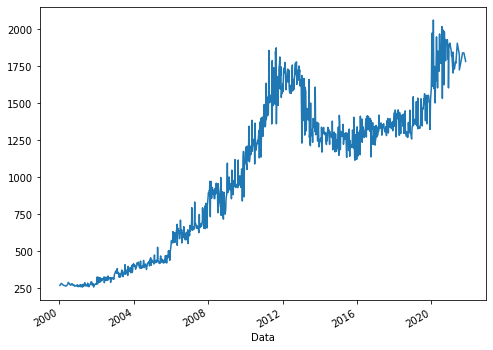

In [753]:
data['Valor'].plot(figsize=(8,6))

# Centering and Normalizing

Não há necessidade de fazer normalização, pois os dados possuem a mesma unidade. Logo não há casos de operações entre dados com unidades ou magnitudes diferentes. 

In [754]:
test_data = data[-100:]
train_data = data[:-100]



train_data.shape

(996, 1)

In [755]:
def get_lagged_features(df, n_steps, n_steps_ahead):
    """
    df: pandas DataFrame of time series to be lagged
    n_steps: number of lags, i.e. sequence length
    n_steps_ahead: forecasting horizon
    """
    lag_list = []
    
    for lag in range(n_steps + n_steps_ahead - 1, n_steps_ahead - 1, -1):
        lag_list.append(df.shift(lag))
    lag_array = np.hstack([i[n_steps+n_steps_ahead-1:] for i in lag_list])
    return lag_array

In [756]:
lst = [x if x < 8 else x-16 for x in range(16)]

train_data.iloc[lst, :]

,Valor
Data,
2000-06-18,282.7
2000-06-25,290.1
2000-02-07,283.2
2000-09-07,281.1
2000-07-16,280.1
2000-07-23,277.7
2000-07-30,272.6
2000-06-08,275.1
2019-05-26,1349.6


In [757]:

train_data

,Valor
Data,
2000-06-18,282.7
2000-06-25,290.1
2000-02-07,283.2
2000-09-07,281.1
2000-07-16,280.1
...,...
2019-06-16,1432.7
2019-06-23,1446.8
2019-06-30,1436.6


In [758]:
window_size = 4
# X train do not use last value, there's no future value to be predicted
x_train = get_lagged_features(train_data, window_size, 1)


y_train =  train_data.values[4:]
y_train_timestamps = train_data.index[:4]


check_data = df(x_train)
check_data["Y"] = y_train

y_train_change = df(check_data['Y'].values - check_data[window_size-1].values)
check_data["Y-change"] = y_train_change


assert ( all ( (check_data['Y'][:-1].values) - (check_data['Y'][1:].values) == -check_data['Y-change'][1:].values) ) #quick test


check_data[::]

,0,1,2,3,Y,Y-change
0,282.7,290.1,283.2,281.1,280.1,-1.0
1,290.1,283.2,281.1,280.1,277.7,-2.4
2,283.2,281.1,280.1,277.7,272.6,-5.1
3,281.1,280.1,277.7,272.6,275.1,2.5
4,280.1,277.7,272.6,275.1,276.8,1.7
...,...,...,...,...,...,...
987,1330.1,1349.6,1381.9,1381.5,1432.7,51.2
988,1349.6,1381.9,1381.5,1432.7,1446.8,14.1
989,1381.9,1381.5,1432.7,1446.8,1436.6,-10.2
990,1381.5,1432.7,1446.8,1436.6,1450.9,14.3


In [759]:
tmp_y_train_change = y_train - (np.array([x_train[:,window_size-1]]).T)

cmp_change = y_train[1:] - y_train[:-1]

assert all ((tmp_y_train_change[1:] == cmp_change))

In [760]:
from sklearn.linear_model import LinearRegression

tscv = TimeSeriesSplit(n_splits = 5)

for train_index, test_index in tscv.split(x_train):
    print("TRAIN:", train_index.shape, "TEST:", test_index.shape)
    #X_train, X_test = X[train_index], X[test_index]
    #y_train, y_test = y[train_index], y[test_index]

tscv_same_size = TimeSeriesSplit(n_splits = 5, max_train_size=157)
for train_index, test_index in tscv_same_size.split(x_train):
    print("TRAIN:", train_index.shape, "TEST:", test_index.shape)



TRAIN: (167,) TEST: (165,)
TRAIN: (332,) TEST: (165,)
TRAIN: (497,) TEST: (165,)
TRAIN: (662,) TEST: (165,)
TRAIN: (827,) TEST: (165,)
TRAIN: (157,) TEST: (165,)
TRAIN: (157,) TEST: (165,)
TRAIN: (157,) TEST: (165,)
TRAIN: (157,) TEST: (165,)
TRAIN: (157,) TEST: (165,)


In [761]:
lin = LinearRegression()
default_rmes = cross_val_score(lin, x_train, y_train, cv=tscv, scoring='neg_root_mean_squared_error', verbose=0)

print(-mean(default_rmes))

26.269651547551618


In [762]:
from sklearn.model_selection import RandomizedSearchCV

def evaluate_regressor (X, y, regressor, params, cross_validator, n_it=10,scorer='neg_root_mean_squared_error'):

    
    rnd_search = RandomizedSearchCV(regressor(), 
                                    params, 
                                    n_iter = n_it, 
                                    cv=cross_validator, 
                                    scoring=scorer,
                                    n_jobs=12)
    rnd_search.fit(X, y)

    return rnd_search.best_score_,  rnd_search.best_params_



In [763]:
# Test function with Linear Regression

rmse, params = evaluate_regressor(x_train, y_train, LinearRegression, {}, tscv, 1)

print(rmse, params)

-26.269651547551614 {}


In [764]:
# Test with L2 Regulator
from sklearn.linear_model import Ridge
from sklearn.utils.fixes import loguniform

parameters = {
    'alpha': loguniform(10**-3, 10**3)
    }

rmse, params = evaluate_regressor(X=x_train,
                                  y=y_train, 
                                  regressor=Ridge, 
                                  params   =parameters, 
                                  cross_validator = tscv, 
                                  n_it=10)
print(rmse, params)

-26.26965160728393 {'alpha': 0.001718838677987792}


In [765]:
# Generate all regressors and parameters
import pprint
from sklearn.linear_model import Lasso
from sklearn.svm import SVR
import random
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neural_network import MLPRegressor
import scipy.stats as stats
from sklearn.tree import DecisionTreeRegressor
from scipy.stats import uniform
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor

test_model = {

    'Linear Regression': {
        'regressor' : LinearRegression,
        'parameters': {},
        'n_iter'    : 1,
        'results'   : {}
    },
    'Ridge': {
        'regressor': Ridge,
        'parameters': {
            'alpha': loguniform(10**-6, 10**6),
            'max_iter': [2000]
        },
        'n_iter'    : 100,
        'results' : {}
    },
    'Lasso': {
        'regressor': Lasso,
        'parameters': {
            'alpha': loguniform(10**-6, 10**6),
            'max_iter': [5000]
        },
        'n_iter' : 100,
        'results' : {}
    },
    'SVM Linear':{
        'regressor': SVR,
        'parameters': {
            'C'      : loguniform(2**-5, 2**15),
            'epsilon': [0.01,0.1,0.2,0.3,0.4],
            'kernel' : ['linear'],
            'max_iter': [5000]
            },
        'n_iter' : 100,
        'results' : {}
    },
    'SVM RBF':{
        'regressor': SVR,
        'parameters': {
            'C'      : loguniform(2**-10, 2**20),
            'epsilon': [0.01,0.1,0.2,0.3,0.4],
            'gamma'  : loguniform(2**-12, 2**6),
            'kernel' : ['rbf'],
            'max_iter': [5000]
            },
        'n_iter' : 100,
        'results' : {}
    },
    'K-Nearest Neighbors': {
        'regressor': KNeighborsRegressor,
        'parameters': {
            'n_neighbors': stats.randint(1,1000)
            },
        'n_iter' : 100,
        'results' : {} 
    },
    'Multi-layer Perceptron': {
        'regressor': MLPRegressor,
        'parameters': {
            'hidden_layer_sizes': np.arange(5, 29+1, 3),
            'max_iter': [5000]
            },
        'n_iter' : 9,
        'results' : {} 
    },
    'Decision Tree': {
        'regressor': DecisionTreeRegressor,
        'parameters': {
            'ccp_alpha': uniform(loc=0.0, scale=0.04)
            },
        'n_iter' : 100,
        'results' : {} 
    },
    'Random Forest': {
        'regressor': RandomForestRegressor,
        'parameters': {
            'n_estimators': [10, 30, 100, 300, 1000],
            'max_features': ['auto', 'sqrt', 'log2']
            },
        'n_iter' : 15,
        'results' : {} 
    },
    'Gradient Boost Machine': {
        'regressor': GradientBoostingRegressor,
        'parameters': {
            'n_estimators': np.arange(5, 101, 1),
            'learning_rate': uniform(loc=0.01, scale=(0.3-0.01)),
            'max_depth': [2,3,4,5]
            },
        'n_iter' : 100,
        'results' : {} 
    }
}






In [766]:
for w_size in [1,2,3,4,5,10,15,20,50]:

    x_train = get_lagged_features(train_data, w_size, 1)
    
    y_train = train_data.values[w_size:]

    #Subtract Y from the most recent column from x
    y_train_change = y_train - (np.array([x_train[:,w_size-1]]).T)
    cmp_change = y_train[1:] - y_train[:-1]
    assert all ((y_train_change[1:] == cmp_change)) #quick test
   
    for regressor in test_model.keys():
        rmse, params = evaluate_regressor(  X=x_train,
                                            y=y_train, 
                                            regressor=test_model[regressor]['regressor'], 
                                            params   =test_model[regressor]['parameters'], 
                                            cross_validator = tscv, 
                                            n_it     =test_model[regressor]['n_iter'])
        
        
        test_model[regressor]['results'][str(w_size)]               = {}                                    
        test_model[regressor]['results'][str(w_size)]['y-absolute'] = {}
        test_model[regressor]['results'][str(w_size)]['y-absolute']['unequal_size'] = {}

        test_model[regressor]['results'][str(w_size)]['y-absolute']['unequal_size']['RMSE']    = -rmse
        test_model[regressor]['results'][str(w_size)]['y-absolute']['unequal_size']['hparams'] = params

        rmse, params = evaluate_regressor(  X=x_train,
                                            y=y_train, 
                                            regressor=test_model[regressor]['regressor'], 
                                            params   =test_model[regressor]['parameters'], 
                                            cross_validator = tscv_same_size, 
                                            n_it     =test_model[regressor]['n_iter'])
        
        test_model[regressor]['results'][str(w_size)]['y-absolute']['same_size'] = {}

        test_model[regressor]['results'][str(w_size)]['y-absolute']['same_size']['RMSE']    = -rmse
        test_model[regressor]['results'][str(w_size)]['y-absolute']['same_size']['hparams'] = params
        
        
        rmse, params = evaluate_regressor(  X=x_train,
                                            y=y_train_change, 
                                            regressor=test_model[regressor]['regressor'], 
                                            params   =test_model[regressor]['parameters'], 
                                            cross_validator = tscv, 
                                            n_it     =test_model[regressor]['n_iter'])
        
        test_model[regressor]['results'][str(w_size)]['y-change'] = {}
        test_model[regressor]['results'][str(w_size)]['y-change']['unequal_size'] = {}
        
        test_model[regressor]['results'][str(w_size)]['y-change']['unequal_size']['RMSE']    = -rmse
        test_model[regressor]['results'][str(w_size)]['y-change']['unequal_size']['hparams'] = params

        rmse, params = evaluate_regressor(  X=x_train,
                                            y=y_train_change, 
                                            regressor=test_model[regressor]['regressor'], 
                                            params   =test_model[regressor]['parameters'], 
                                            cross_validator = tscv_same_size, 
                                            n_it     =test_model[regressor]['n_iter'])
        
        test_model[regressor]['results'][str(w_size)]['y-change']['same_size'] = {}
        
        test_model[regressor]['results'][str(w_size)]['y-change']['same_size']['RMSE']    = -rmse
        test_model[regressor]['results'][str(w_size)]['y-change']['same_size']['hparams'] = params


    nan           nan           nan           nan           nan
 -306.56863664           nan           nan           nan           nan
 -214.81547174           nan           nan           nan           nan
           nan -320.67102357 -261.32792512 -304.32306048           nan
           nan           nan           nan -250.6071616  -331.33721671
 -280.80395215 -327.22840581 -267.78298512           nan           nan
           nan           nan           nan           nan           nan
           nan           nan -261.32792512           nan           nan
           nan           nan           nan           nan           nan
           nan           nan           nan           nan           nan
           nan           nan           nan           nan           nan
           nan           nan -237.16898035 -233.87842041 -314.96290888
           nan           nan           nan           nan           nan
 -308.76598344           nan           nan           nan           nan]
  warnings.w

In [767]:
pprint.pprint(test_model)

   'epsilon': 0.2,
                                                                        'gamma': 0.0007013492765972321,
                                                                        'kernel': 'rbf',
                                                                        'max_iter': 5000}},
                                              'unequal_size': {'RMSE': 280.93344690765974,
                                                               'hparams': {'C': 16784.720685917768,
                                                                           'epsilon': 0.3,
                                                                           'gamma': 0.0014017191534737158,
                                                                           'kernel': 'rbf',
                                                                           'max_iter': 5000}}},
                               'y-change': {'same_size': {'RMSE': 26.27834284906561,
                                  

In [768]:

%%capture cap
pprint.pprint(test_model)
with open('test_model_absolute_change_sizes.txt', 'w') as f:
    f.write(cap.stdout)